<a href="https://colab.research.google.com/github/elliecheshire/Stop_and_Search/blob/main/Consulting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import networkx as nx
from collections import defaultdict
from matplotlib import cm

### Data Loading

In [4]:
#Data Loading

articles = pd.read_csv('/content/drive/MyDrive/Group 1/articles.CDKN2A.csv')
authors = pd.read_csv('/content/drive/MyDrive/Group 1/authors.CDKN2A.csv')
paper_counts = pd.read_csv('/content/drive/MyDrive/Group 1/paper_counts.csv')

In [5]:
articles.head()

,PMID,Title,Abstract,ISSN,Journal,Location,Year,FirstAuthorForename,FirstAuthorLastname,FirstAuthorInitials,FirstAuthorAffiliation
0,10551774,Transfection of an inducible p16/CDKN2A constr...,Recent studies have shown that methylation of ...,0888-8809,"Molecular endocrinology (Baltimore, Md.)",(13) 1801-10,1999,S J,Frost,SJ,"Centre for Cell and Molecular Medicine, School..."
1,10595918,Malignant transformation of neurofibromas in n...,Patients with neurofibromatosis 1 (NF1) are pr...,0002-9440,The American journal of pathology,(155) 1879-84,1999,G P,Nielsen,GP,Molecular Neuro-Oncology Laboratory and the Ja...
2,10620111,Genotype/phenotype and penetrance studies in m...,Patients with a family history of melanoma are...,0022-202X,The Journal of investigative dermatology,(114) 28-33,2000,J A,Bishop,JA,"ICRF Genetic Epidemiology Laboratory, Leeds, U..."
3,10630172,The genetics of hereditary melanoma and nevi. ...,Although the first English-language report of ...,0008-543X,Cancer,(86) 2464-77,1999,M H,Greene,MH,"Division of Hematology/Oncology, Mayo Clinic S..."
4,10632344,Analysis of oncogene and tumor suppressor gene...,Although common among adult intracranial neopl...,1078-0432,Clinical cancer research : an official journal...,(5) 4085-90,1999,C,Raffel,C,"Department of Neurosurgery, Mayo Clinic and Fo..."


In [6]:
authors.head()

,PMID,AuthorN,AuthorForename,AuthorLastname,AuthorInitials,AuthorAffiliation
0,10551774,1,S J,Frost,SJ,"Centre for Cell and Molecular Medicine, School..."
1,10551774,2,D J,Simpson,DJ,NaN
2,10551774,3,R N,Clayton,RN,NaN
3,10551774,4,W E,Farrell,WE,NaN
4,10595918,1,G P,Nielsen,GP,Molecular Neuro-Oncology Laboratory and the Ja...


In [7]:
paper_counts.head()

,Year,Count
0,1799,1
1,1801,1
2,1802,1
3,1805,1
4,1866,1


### Data Cleaning

In [8]:
# Data Cleaning: Handle Missing Values and Remove Duplicates
# Handle missing values in `authors_df`
authors['AuthorForename'].fillna('Unknown', inplace=True)
authors['AuthorInitials'].fillna('Unknown', inplace=True)
authors.dropna(subset=['AuthorLastname'], inplace=True)

<ipython-input-8-dcf0bb612f25>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  authors['AuthorForename'].fillna('Unknown', inplace=True)
<ipython-input-8-dcf0bb612f25>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

In [9]:
# Handle missing values in `articles_df`
articles.fillna({
    'Location': 'Unknown',
    'FirstAuthorForename': 'Unknown',
    'FirstAuthorLastname': 'Unknown',
    'FirstAuthorInitials': 'Unknown',
    'FirstAuthorAffiliation': 'Unknown'
}, inplace=True)

In [10]:
# Remove duplicates
articles.drop_duplicates(inplace=True)
authors.drop_duplicates(inplace=True)
paper_counts.drop_duplicates(inplace=True)

In [11]:
#checking for missing values
print(articles.isnull().sum())
print(authors.isnull().sum())
print(paper_counts.isnull().sum())

PMID                      0
Title                     0
Abstract                  0
ISSN                      0
Journal                   0
Location                  0
Year                      0
FirstAuthorForename       0
FirstAuthorLastname       0
FirstAuthorInitials       0
FirstAuthorAffiliation    0
dtype: int64
PMID                     0
AuthorN                  0
AuthorForename           0
AuthorLastname           0
AuthorInitials           0
AuthorAffiliation    13123
dtype: int64
Year     0
Count    0
dtype: int64


In [12]:
# Data Manipulation: Merge and Create Unique Identifiers
# Merge `authors_df` and `articles_df` on `PMID`
merged_df = pd.merge(authors, articles, on='PMID', how='inner')

In [13]:
# Create a unique identifier for researchers
merged_df['ResearcherID'] = merged_df['AuthorLastname'] + '_' + merged_df['AuthorInitials']
merged_df.head()

,PMID,AuthorN,AuthorForename,AuthorLastname,AuthorInitials,AuthorAffiliation,Title,Abstract,ISSN,Journal,Location,Year,FirstAuthorForename,FirstAuthorLastname,FirstAuthorInitials,FirstAuthorAffiliation,ResearcherID
0,10551774,1,S J,Frost,SJ,"Centre for Cell and Molecular Medicine, School...",Transfection of an inducible p16/CDKN2A constr...,Recent studies have shown that methylation of ...,0888-8809,"Molecular endocrinology (Baltimore, Md.)",(13) 1801-10,1999,S J,Frost,SJ,"Centre for Cell and Molecular Medicine, School...",Frost_SJ
1,10551774,2,D J,Simpson,DJ,NaN,Transfection of an inducible p16/CDKN2A constr...,Recent studies have shown that methylation of ...,0888-8809,"Molecular endocrinology (Baltimore, Md.)",(13) 1801-10,1999,S J,Frost,SJ,"Centre for Cell and Molecular Medicine, School...",Simpson_DJ
2,10551774,3,R N,Clayton,RN,NaN,Transfection of an inducible p16/CDKN2A constr...,Recent studies have shown that methylation of ...,0888-8809,"Molecular endocrinology (Baltimore, Md.)",(13) 1801-10,1999,S J,Frost,SJ,"Centre for Cell and Molecular Medicine, School...",Clayton_RN
3,10551774,4,W E,Farrell,WE,NaN,Transfection of an inducible p16/CDKN2A constr...,Recent studies have shown that methylation of ...,0888-8809,"Molecular endocrinology (Baltimore, Md.)",(13) 1801-10,1999,S J,Frost,SJ,"Centre for Cell and Molecular Medicine, School...",Farrell_WE
4,10595918,1,G P,Nielsen,GP,Molecular Neuro-Oncology Laboratory and the Ja...,Malignant transformation of neurofibromas in n...,Patients with neurofibromatosis 1 (NF1) are pr...,0002-9440,The American journal of pathology,(155) 1879-84,1999,G P,Nielsen,GP,Molecular Neuro-Oncology Laboratory and the Ja...,Nielsen_GP


In [14]:
# create a dataframe with only papers which have 'cancer' in them
cancer_rows = merged_df[merged_df['Abstract'].str.contains('cancer', case=False, na=False)]

print(cancer_rows)

cancer_count = cancer_rows.shape[0]
print(f"Number of rows where 'Abstract' contains the word 'cancer': {cancer_count}")

           PMID  AuthorN AuthorForename AuthorLastname AuthorInitials  \
19     10630172        1            M H         Greene             MH   
27     10644453        1            B G         Beatty             BG   
28     10644453        2              S             Qi              S   
29     10644453        3              M     Pienkowska              M   
30     10644453        4            J A       Herbrick             JA   
...         ...      ...            ...            ...            ...   
35705  38070141        3        Xiaoxue           Yuan              X   
35706  38070141        4         Mengqi            Liu              M   
35707  38070141        5           Ping             Wu              P   
35708  38070141        6             Li          Zhong              L   
35709  38070141        7        Zhiyong           Chen              Z   

                                       AuthorAffiliation  \
19     Division of Hematology/Oncology, Mayo Clinic S...   
27 

### Most active researchers

In [15]:
# Count the number of papers each researcher has been involved in
author_counts = cancer_rows['ResearcherID'].value_counts().reset_index()
author_counts.columns = ['ResearcherID', 'Count']
# Sort into descending order
author_counts = author_counts.sort_values(by='Count', ascending=False)
most_published_authors = author_counts.head(10)
print(most_published_authors)
most_published_authors = pd.DataFrame(most_published_authors)

# Display the dataframe
display(most_published_authors)

   ResearcherID  Count
0        Wang_Y     27
1      Fuchs_CS     26
2       Ogino_S     25
3     Hruban_RH     23
4        Wang_J     22
5  Goldstein_AM     21
6       Zhang_Y     20
9    Kirkner_GJ     19
8       Zhang_J     19
7          Li_J     19


,ResearcherID,Count
0,Wang_Y,27
1,Fuchs_CS,26
2,Ogino_S,25
3,Hruban_RH,23
4,Wang_J,22
5,Goldstein_AM,21
6,Zhang_Y,20
9,Kirkner_GJ,19
8,Zhang_J,19
7,Li_J,19


### Collaboration Patterns

In [16]:
# create dataframes
df_coauthored = []
df_no_coauthored = []

# get the researcherID of the most published authors
top_10_authors = most_published_authors['ResearcherID'][:10]

# create pairs of researchers to check if they have collaborated
author_pairs = list(combinations(top_10_authors, 2))

# create a dictionary to store the pair and the papers they've co-authored
coauthored_together = {pair: set() for pair in author_pairs}

# create a collaboration dataframe with columns PMID and ResearcherID
collaboration = cancer_rows[['PMID', 'ResearcherID']].copy()

# group by PMID and  ResearcherIDs into a list of collaborators
collaboration = collaboration.groupby('PMID')['ResearcherID'].agg(lambda x: ','.join(x)).reset_index()
collaboration.columns = ['PMID', 'Collaborators']

paper_to_collaborators = collaboration.set_index('PMID')['Collaborators'].to_dict()

# for each pair of top 10 authors, check if they have co-authored any paper
for paper_id, collaborators in paper_to_collaborators.items():
    collaborators = collaborators.split(',')
    collaborator_set = set(collaborators)
    # check each pair of top 10 authors
    for author1, author2 in author_pairs:
        # if both authors are in the set of collaborators for this paper, they have co-authored it
        if author1 in collaborator_set and author2 in collaborator_set:
            coauthored_together[(author1, author2)].add(paper_id)

# print out the pairs and the papers they've co-authored
for (author1, author2), papers in coauthored_together.items():
  # if there are co-authored papers then print the authors and papers
  if len(papers) > 0:
    print(f'{author1} and {author2} have co-authored {len(papers)} papers: {papers}')
    # add to the dataframe
    df_coauthored.append({'Author 1': author1,
                          'Author 2': author2,
                          'Co-authored Papers': list(papers)})
  else:
    # if there are no authored papers
    print(f'{author1} and {author2} have not co-authored any papers.')
    # add to the dataframe
    df_no_coauthored.append({'Author 1': author1,
                          'Author 2': author2,
                          'Co-authored Papers': 0})

df_coauthored = pd.DataFrame(df_coauthored)
df_no_coauthored = pd.DataFrame(df_no_coauthored)


Wang_Y and Fuchs_CS have not co-authored any papers.
Wang_Y and Ogino_S have not co-authored any papers.
Wang_Y and Hruban_RH have co-authored 1 papers: {26658419}
Wang_Y and Wang_J have co-authored 2 papers: {22510280, 29667179}
Wang_Y and Goldstein_AM have not co-authored any papers.
Wang_Y and Zhang_Y have co-authored 2 papers: {22208613, 28926119}
Wang_Y and Kirkner_GJ have not co-authored any papers.
Wang_Y and Zhang_J have co-authored 2 papers: {29667179, 22815924}
Wang_Y and Li_J have not co-authored any papers.
Fuchs_CS and Ogino_S have co-authored 24 papers: {18084616, 17350669, 18204436, 19430421, 19002263, 18084250, 21037082, 19107235, 19789368, 20473920, 18516290, 16850502, 17710160, 17065427, 17372756, 17621591, 16645207, 17086168, 17270239, 16699497, 18366060, 17591929, 17239930, 16820091}
Fuchs_CS and Hruban_RH have co-authored 1 papers: {27197284}
Fuchs_CS and Wang_J have not co-authored any papers.
Fuchs_CS and Goldstein_AM have not co-authored any papers.
Fuchs_CS and

In [17]:
# List of authors who have worked together and the papers they have co-authored
# count the number of co-authored papers
df_coauthored['Number of Co-authored Papers'] = df_coauthored['Co-authored Papers'].apply(len)

df_coauthored

,Author 1,Author 2,Co-authored Papers,Number of Co-authored Papers
0,Wang_Y,Hruban_RH,[26658419],1
1,Wang_Y,Wang_J,"[22510280, 29667179]",2
2,Wang_Y,Zhang_Y,"[22208613, 28926119]",2
3,Wang_Y,Zhang_J,"[29667179, 22815924]",2
4,Fuchs_CS,Ogino_S,"[18084616, 17350669, 18204436, 19430421, 19002...",24
5,Fuchs_CS,Hruban_RH,[27197284],1
6,Fuchs_CS,Kirkner_GJ,"[18084616, 17350669, 18204436, 19002263, 18084...",19
7,Ogino_S,Kirkner_GJ,"[18084616, 17350669, 18204436, 19002263, 18084...",19
8,Hruban_RH,Wang_J,"[28272465, 21798897]",2
9,Hruban_RH,Zhang_J,[21798897],1


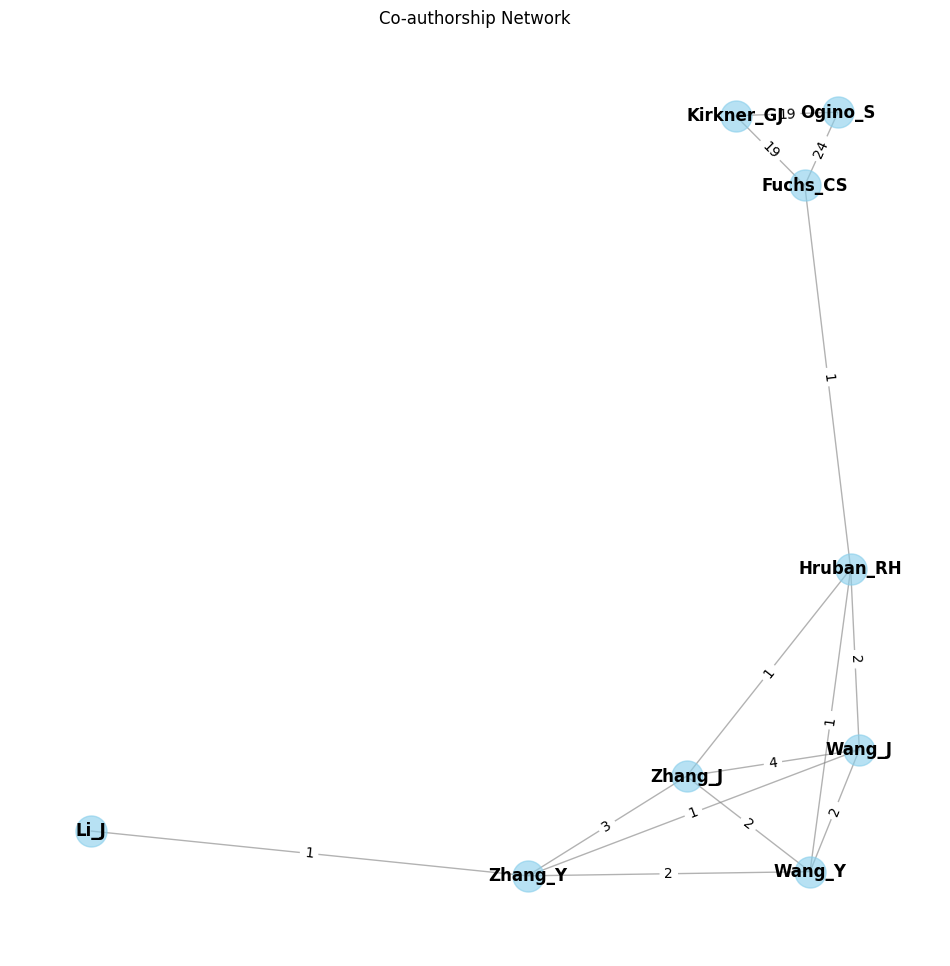

In [18]:
# create a graph
collaboration_network = nx.Graph()

# loop through your dataframe to add lines between researchers
for _, row in df_coauthored.iterrows():
    author1 = row['Author 1']
    author2 = row['Author 2']
    # add number of papers they co-authored
    num_papers = len(row['Co-authored Papers'])

    collaboration_network.add_edge(author1, author2, weight=num_papers)

# draw the network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(collaboration_network, k=0.5)
nx.draw_networkx_nodes(collaboration_network, pos, node_size=500, node_color="skyblue", alpha=0.6)
nx.draw_networkx_edges(collaboration_network, pos, width=1.0, alpha=0.6, edge_color="gray")
nx.draw_networkx_labels(collaboration_network, pos, font_size=12, font_weight='bold')

edge_labels = nx.get_edge_attributes(collaboration_network, 'weight')
nx.draw_networkx_edge_labels(collaboration_network, pos, edge_labels=edge_labels)

plt.title("Co-authorship Network")
plt.axis("off")
plt.show()


In [19]:
# The list of authors that has not colloborated with the papers in common
df_no_coauthored

,Author 1,Author 2,Co-authored Papers
0,Wang_Y,Fuchs_CS,0
1,Wang_Y,Ogino_S,0
2,Wang_Y,Goldstein_AM,0
3,Wang_Y,Kirkner_GJ,0
4,Wang_Y,Li_J,0
5,Fuchs_CS,Wang_J,0
6,Fuchs_CS,Goldstein_AM,0
7,Fuchs_CS,Zhang_Y,0
8,Fuchs_CS,Zhang_J,0
9,Fuchs_CS,Li_J,0


<ipython-input-20-a757bafaa740>:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(top_10_cancer_authors))  # Use a colormap for distinct colors


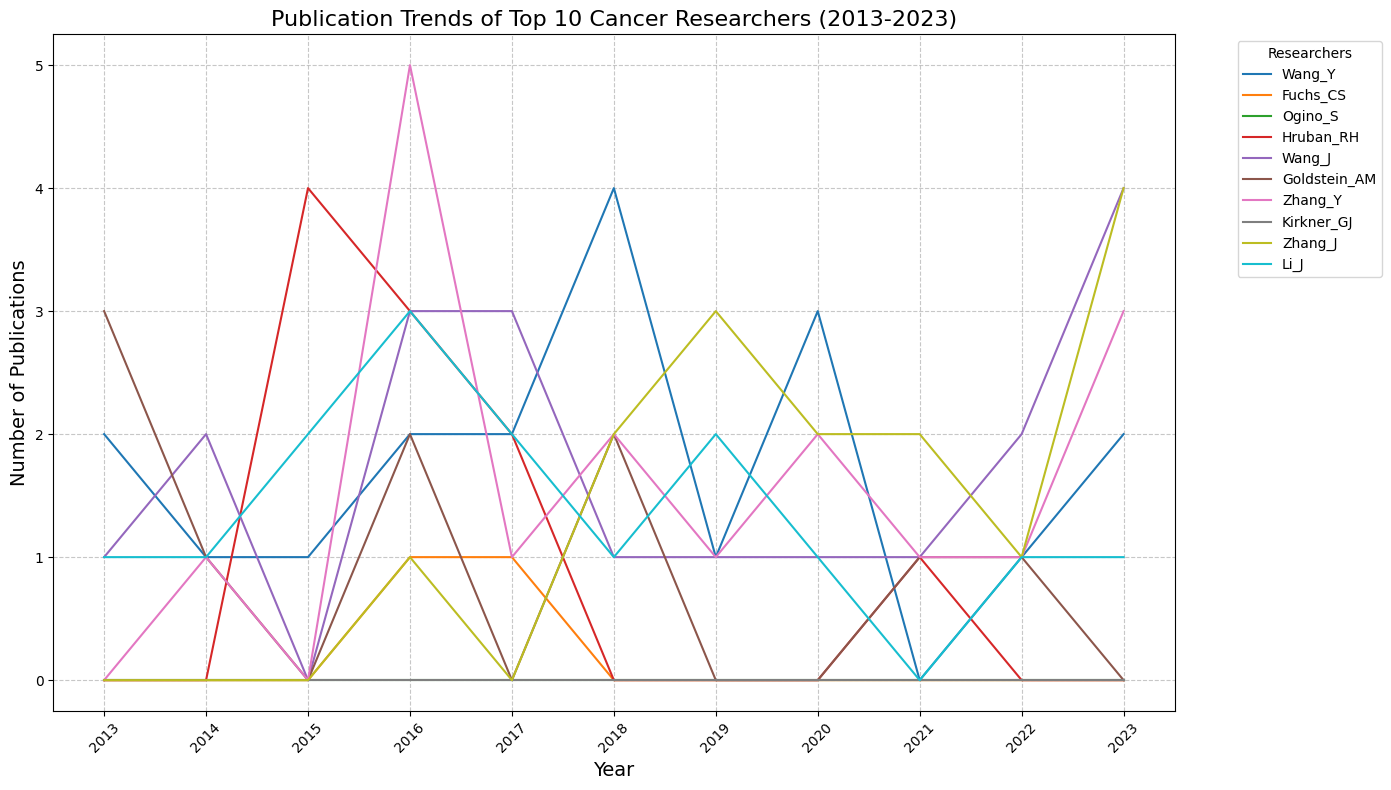

Number of rows where 'Abstract' contains the word 'cancer': 14370


In [20]:
# Filter data for rows where 'Abstract' contains the word 'cancer'
cancer_rows = merged_df[merged_df['Abstract'].str.contains('cancer', case=False, na=False)]

# Count the number of papers each researcher has been involved in
author_counts = cancer_rows['ResearcherID'].value_counts().reset_index()
author_counts.columns = ['ResearcherID', 'Count']
# Sort into descending order
author_counts = author_counts.sort_values(by='Count', ascending=False)
most_published_authors = author_counts.head(10)

# Extract the top 10 cancer researchers
top_10_cancer_authors = most_published_authors['ResearcherID'].tolist()

# Further filter data for the years 2014-2024
filtered_cancer_data = cancer_rows[(cancer_rows['Year'] >= 2013) & (cancer_rows['Year'] <= 2023)]

# Filter the data to include only the top 10 cancer researchers
top_cancer_authors_data = filtered_cancer_data[filtered_cancer_data['ResearcherID'].isin(top_10_cancer_authors)]

# Group by Year and ResearcherID, and count publications
yearly_cancer_publications = (
    top_cancer_authors_data.groupby(['Year', 'ResearcherID'])
    .size()
    .reset_index(name='PublicationCount')
)

# Pivot the data for easier plotting
pivot_cancer_data = yearly_cancer_publications.pivot(index='Year', columns='ResearcherID', values='PublicationCount').fillna(0)

# Add missing researchers with zero publications for all years in the range
for researcher in top_10_cancer_authors:
    if researcher not in pivot_cancer_data.columns:
        pivot_cancer_data[researcher] = 0

# Re-sort the columns to maintain the order of top 10 authors
pivot_cancer_data = pivot_cancer_data[top_10_cancer_authors]

# Plot the line graph
plt.figure(figsize=(14, 8))
colors = cm.get_cmap('tab10', len(top_10_cancer_authors))  # Use a colormap for distinct colors

for i, researcher in enumerate(top_10_cancer_authors):
    plt.plot(pivot_cancer_data.index, pivot_cancer_data[researcher], label=researcher, color=colors(i))

# Customizing the plot
plt.title('Publication Trends of Top 10 Cancer Researchers (2013-2023)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Publications', fontsize=14)
plt.xticks(range(2013, 2024), rotation=45)
plt.legend(title='Researchers', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

# Count the total number of rows in the cancer dataset
cancer_count = cancer_rows.shape[0]
print(f"Number of rows where 'Abstract' contains the word 'cancer': {cancer_count}")


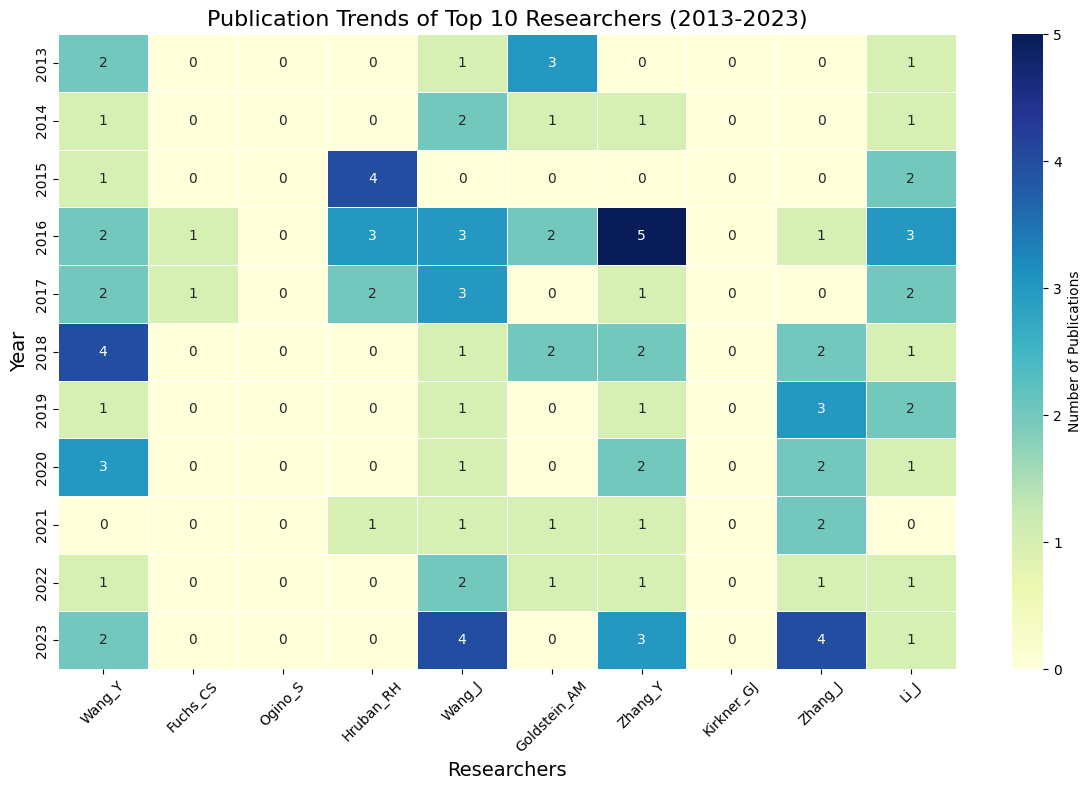

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap for publication trends
plt.figure(figsize=(12, 8))
heatmap_data = pivot_cancer_data

sns.heatmap(
    heatmap_data,
    annot=True,
    fmt="g",
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={"label": "Number of Publications"}
)

# Customizing the plot
plt.title("Publication Trends of Top 10 Researchers (2013-2023)", fontsize=16)
plt.xlabel("Researchers", fontsize=14)
plt.ylabel("Year", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the heatmap
plt.show()


### Topic development over time

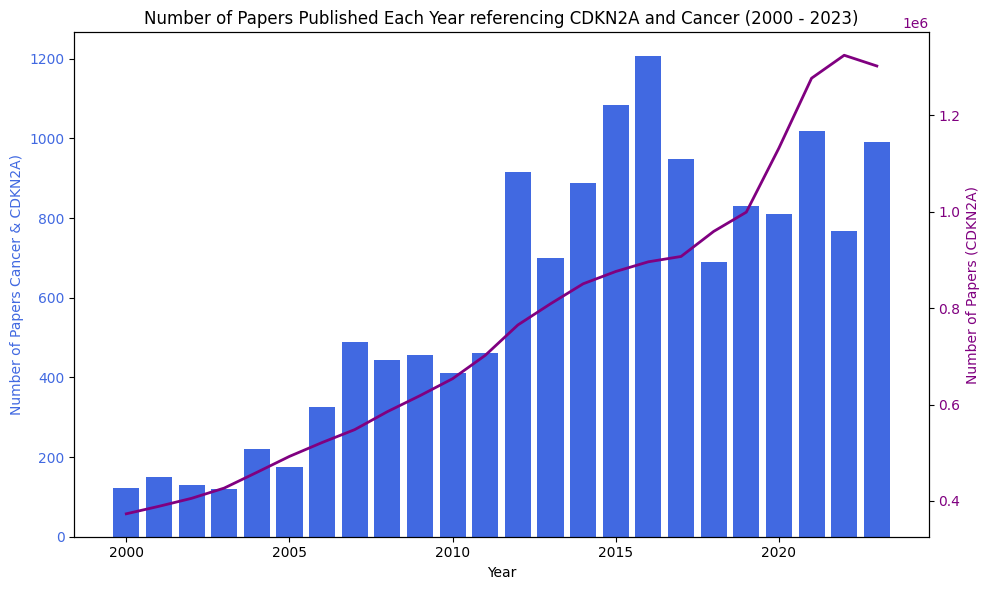

In [26]:
# using the paper_counts dataframe filter to only have years 2000-2023
filtered_paper_counts = paper_counts[(paper_counts['Year'] >= 2000)& (paper_counts['Year'] <= 2023)]
# count the number of papers per year in the dataframe of cancer related papers
cancer_paper_counts = cancer_rows.groupby('Year').size().reset_index(name='Count')
# filter only years 2000 -2023
cancer_paper_counts = cancer_paper_counts[(cancer_paper_counts['Year'] >= 2000)& (cancer_paper_counts['Year'] <= 2023)]


combined_counts, ax1 = plt.subplots(figsize=(10, 6))
# plot the bar chart for cancer paper counts
ax1.bar(cancer_paper_counts['Year'], cancer_paper_counts['Count'], color='royalblue', label='CDKN2A and Cancer', width=0.8)
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Papers Cancer & CDKN2A)', color='royalblue')
ax1.tick_params(axis='y', labelcolor='royalblue')

# create a second y-axis for the line chart
ax2 = ax1.twinx()
ax2.plot(filtered_paper_counts['Year'], filtered_paper_counts['Count'], color='purple', label='CDKN2A', linewidth=2)
ax2.set_ylabel('Number of Papers (CDKN2A)', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

# add the title and show the plot
plt.title('Number of Papers Published Each Year referencing CDKN2A and Cancer (2000 - 2023)')
combined_counts.tight_layout()
plt.show()


In [24]:
filtered_paper_counts

,Year,Count
118,2000,373439
119,2001,388963
120,2002,405519
121,2003,426752
122,2004,459362
123,2005,492511
124,2006,521278
125,2007,548061
126,2008,585286
127,2009,618504


In [ ]:
top_researchers_cancer_rows = cancer_rows[cancer_rows['ResearcherID'].isin(top_10_authors)]

# Group by ResearcherID and JournalName, then count publications
researcher_journal_counts = top_researchers_cancer_rows.groupby(['ResearcherID', 'Journal'])['PMID'].count().reset_index(name='Count')

# Sort by PublicationCount in descending order
researcher_journal_counts = researcher_journal_counts.sort_values(by=['ResearcherID', 'Count'], ascending=[True, False])

# Get the top journal for each researcher
top_journals_by_researcher = researcher_journal_counts.groupby('ResearcherID').first().reset_index()

top_journals_df = top_journals_by_researcher[['ResearcherID', 'Journal', 'Count']]

print("Top Journals by Publication Count for Top Researchers:")
display(top_journals_df)

Top Journals by Publication Count for Top Researchers:


,ResearcherID,Journal,Count
0,Fuchs_CS,Modern pathology : an official journal of the ...,5
1,Goldstein_AM,"Genes, chromosomes & cancer",2
2,Hruban_RH,Cancer biology & therapy,3
3,Kirkner_GJ,"Neoplasia (New York, N.Y.)",5
4,Li_J,Oncotarget,3
5,Ogino_S,Modern pathology : an official journal of the ...,5
6,Wang_J,Oncotarget,3
7,Wang_Y,Cancer medicine,2
8,Zhang_J,Nature communications,3
9,Zhang_Y,American journal of human genetics,2


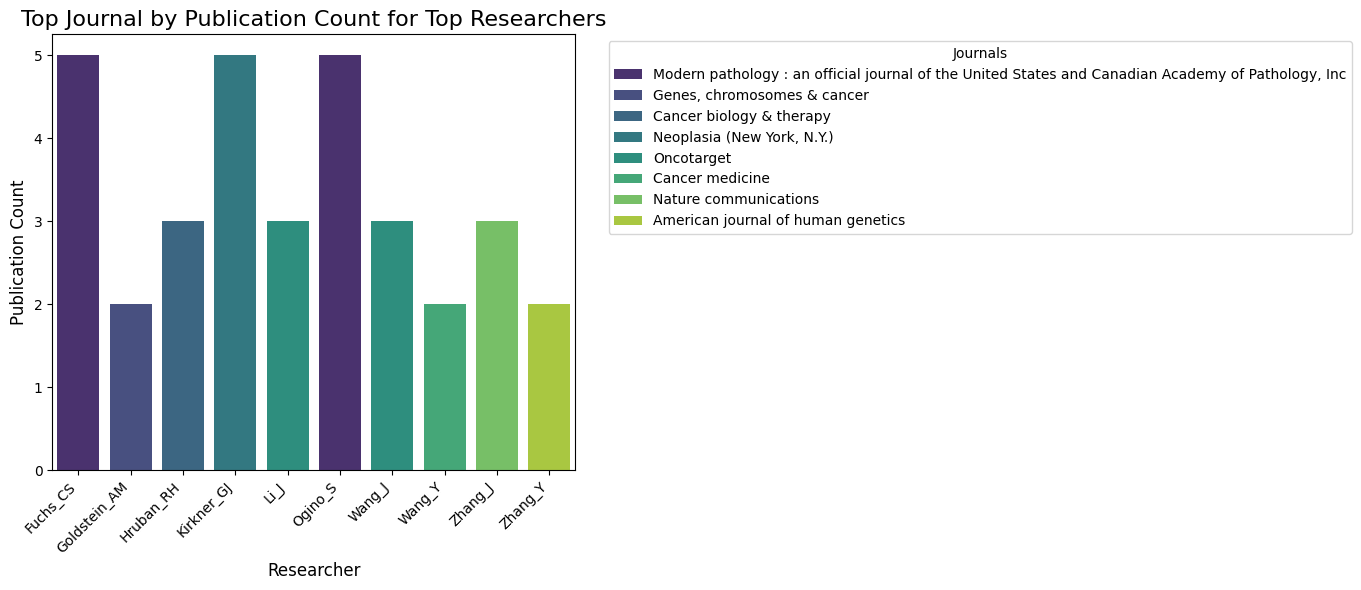

In [ ]:
plt.figure(figsize=(14, 6))
barplot = sns.barplot(x='ResearcherID', y='Count', hue='Journal', data=top_journals_df, palette='viridis')


plt.xticks(rotation=45, ha='right')

# Add titles and labels
plt.title('Top Journal by Publication Count for Top Researchers', fontsize=16)
plt.xlabel('Researcher', fontsize=12)
plt.ylabel('Publication Count', fontsize=12)

plt.xticks(rotation=45, ha='right')

# Move legend outside the plot
plt.legend(title="Journals", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot with tight layout
plt.tight_layout()
plt.show()

In [ ]:
# Combine author and first author affiliations
cancer_rows['AllAffiliations'] = (
    cancer_rows['AuthorAffiliation'].fillna('') + ' ' + cancer_rows['FirstAuthorAffiliation'].fillna('')
)

# Count publications by institutions
top_institutions = cancer_rows['AllAffiliations'].value_counts().head(10)

top_institutions_df = top_institutions.reset_index()
top_institutions_df.columns = ['Institution', 'PublicationCount']

print("Top Institutions by Publication Count:")
display(top_institutions_df)

Top Institutions by Publication Count:


<ipython-input-97-721b8b1a5c8c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancer_rows['AllAffiliations'] = (


,Institution,PublicationCount
0,"Centre for Cancer Genetic Epidemiology, Depar...",180
1,"Epidemiology Research Program, American Cance...",125
2,"The Kinghorn Cancer Centre, 370 Victoria Stre...",125
3,"Genetic Epidemiology Branch, Division of Canc...",76
4,"International Agency for Research on Cancer, ...",65
5,Unknown,60
6,"Translational Research Laboratories, Universi...",43
7,"Université Pierre et Marie Curie-Paris 6, Cen...",39
8,"Department of Genetics and Pathology, Interna...",38
9,"Cancer Genome Project, Wellcome Trust Sanger ...",35
